<a href="https://colab.research.google.com/github/Deep-Dey1/plant-disease-detection/blob/main/Plant_desies_detection_dl_lab_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0
Found 43456 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

🔧 Training Custom_CNN...

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 106s 74ms/step - accuracy: 0.4871 - loss: 2.1997 - val_accuracy: 0.7990 - val_loss: 0.6408
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 94s 69ms/step - accuracy: 0.8578 - loss: 0.4640 - val_accuracy: 0.8268 - val_loss: 0.5503
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 90s 67ms/step - accuracy: 0.9300 - loss: 0.2200 - val_accuracy: 0.8523 - val_loss: 0.5370
Epoch 4/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - accuracy: 0.9658 - loss: 0.1081 - val_accuracy: 0.8428 - val_loss: 0.6537
Epoch 5/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 91s 67ms/step - accuracy: 0.9777 - loss: 0.0705 - val_accuracy: 0.8562 - val_loss: 0.6587

🔧 Training MobileNetV2...

Epoch 1/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 117s 79ms/step - accuracy: 0.8115 - loss: 0.7145 - val_accuracy: 0.9329 - val_loss: 0.2099
Epoch 2/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 92s 68ms/step - accuracy: 0.9478 - loss: 0.1583 - val_accuracy: 0.9428 - val_loss: 0.1743
Epoch 3/5
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 99s 73ms/step - accura

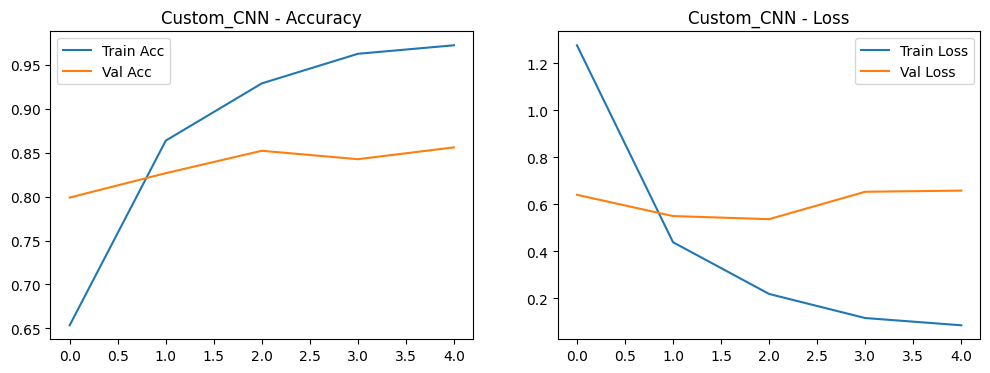

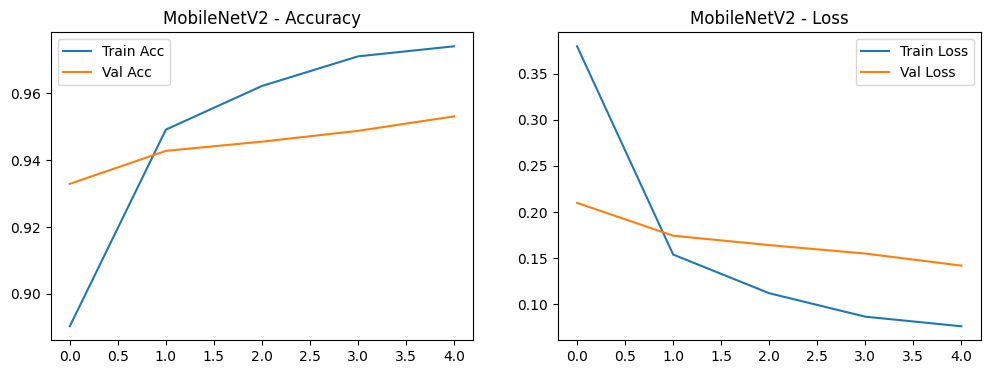

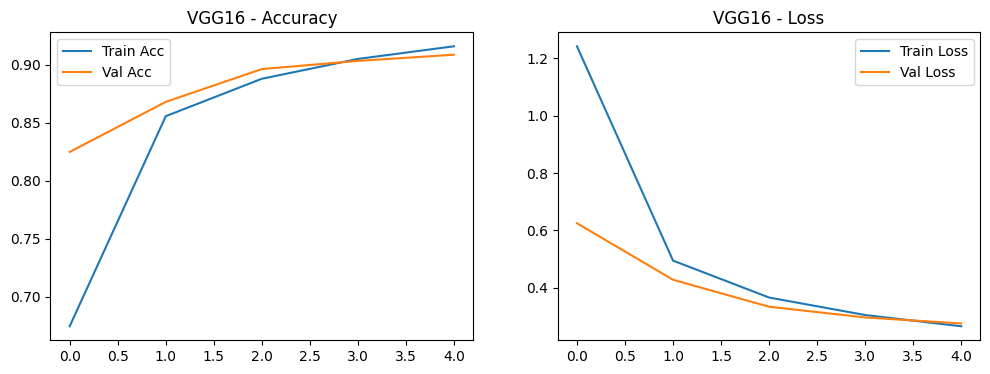

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


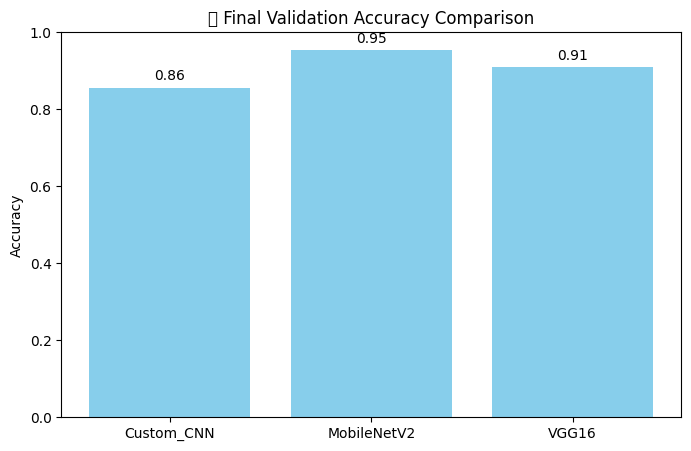

In [1]:

# STEP 1: Set up & Download Dataset

!pip install -q kaggle

import os
from zipfile import ZipFile

# Upload kaggle.json
from google.colab import files
files.upload()  # Upload kaggle.json here

# Set up Kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset
!kaggle datasets download -d abdallahalidev/plantvillage-dataset
!unzip -q plantvillage-dataset.zip -d /content/plantvillage

# STEP 2: Prepare Data

from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "/content/plantvillage/plantvillage dataset/color"
img_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_gen = train_datagen.flow_from_directory(
    data_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

# ===============================
# STEP 3: Define Models
# ===============================
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2, VGG16

def build_custom_cnn(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D(),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def build_transfer_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(include_top=False, input_shape=input_shape, weights='imagenet')
    base_model.trainable = False
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = img_size + (3,)
num_classes = train_gen.num_classes

models_dict = {
    "Custom_CNN": build_custom_cnn(input_shape, num_classes),
    "MobileNetV2": build_transfer_model(MobileNetV2, input_shape, num_classes),
    "VGG16": build_transfer_model(VGG16, input_shape, num_classes)
}

# ===============================
# STEP 4: Train & Evaluate Models
# ===============================
import matplotlib.pyplot as plt

results = {}

for model_name, model in models_dict.items():
    print(f"\n🔧 Training {model_name}...\n")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(
        train_gen,
        epochs=5,  # Increase for better results
        validation_data=val_gen
    )

    # Store results
    results[model_name] = {
        "model": model,
        "history": history
    }

# ===============================
# STEP 5: Plot Results
# ===============================
# Accuracy & Loss plots
for model_name, result in results.items():
    history = result["history"]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} - Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} - Loss')
    plt.legend()
    plt.show()

# Bar chart comparing final validation accuracy
model_names = []
val_accs = []

for model_name, result in results.items():
    acc = result['history'].history['val_accuracy'][-1]
    model_names.append(model_name)
    val_accs.append(acc)

plt.figure(figsize=(8, 5))
plt.bar(model_names, val_accs, color='skyblue')
plt.title("📊 Final Validation Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i, acc in enumerate(val_accs):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')
plt.show()
